### Purpose
Playing around with NB Multinormial language modeling. Eventually need to turn this into a .py file.

In [55]:
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from IPython.core.interactiveshell import InteractiveShell
import classification_pipeline as pipeline
from scipy import sparse


InteractiveShell.ast_node_interactivity = "all"

In [50]:
df = pickle.load(open("../data/movies_lines_train.p", 'rb'))

In [4]:
df.shape
df.head()

(202394, 9)

,movie_id,gender_to,gender_from,char_id_from,char_id_to,line_id,words,movie_year,genre
0,m18,m,m,u284,u288,L34746,hello tom,1932,drama
1,m18,m,m,u284,u288,L34747,you you want,1932,drama
2,m18,m,m,u284,u288,L34748,you suppose anybody want money money money,1932,drama
3,m18,m,m,u284,u288,L34749,listen i tell you i interested deal i,1932,drama
4,m18,m,m,u284,u288,L34750,i want know,1932,drama


In [5]:
df.genre.unique()

array(['drama', 'action', 'adventure', 'horror', 'comedy', 'mystery',
       'animation', 'thriller', 'crime', 'short', 'fantasy', 'biography',
       'documentary', 'sci-fi', 'family'], dtype=object)

In [51]:
df = pipeline.add_columns(df)

In [16]:
df.head()

,movie_id,gender_to,gender_from,char_id_from,char_id_to,line_id,words,movie_year,genre,gender_pair,agency_pos_prop,power_pos_prop,agency_neg_prop,power_neg_prop,MT1,MT2,MT3,WT1,WT2,WT3
0,m18,0,0,u284,u288,L34746,hello tom,1932,drama,0,0.000000,0.0,0.0,0.0,27.474762,31.052752,30.398746,3.368221,3.309822,2.475675
1,m18,0,0,u284,u288,L34747,you you want,1932,drama,0,0.000000,0.0,1.0,1.0,27.471319,32.046505,28.411058,4.286404,3.240317,2.391138
2,m18,0,0,u284,u288,L34748,you suppose anybody want money money money,1932,drama,0,0.000000,0.0,0.5,0.5,30.733057,33.307358,28.655600,4.590682,3.429439,2.629144
3,m18,0,0,u284,u288,L34749,listen i tell you i interested deal i,1932,drama,0,0.333333,0.0,0.0,0.0,27.688360,33.289986,29.672899,3.286407,4.240316,2.391139
4,m18,0,0,u284,u288,L34750,i want know,1932,drama,0,0.000000,0.0,1.0,1.0,27.471331,33.046471,28.411070,4.286404,3.240317,2.391138


In [52]:
FEATURE_COLS = ['words', 'agency_pos_prop','power_pos_prop', 'agency_neg_prop','power_neg_prop',
                'MT1','MT2', 'MT3','WT1','WT2','WT3']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df[FEATURE_COLS], df.gender_from.astype('int'), test_size=0.33, random_state=42)

In [26]:
y_train.value_counts()
y_test.value_counts()

0    73123
1    32331
Name: gender_from, dtype: int64

0    36059
1    15882
Name: gender_from, dtype: int64

In [27]:
X_train.shape
X_test.shape

(105454, 11)

(51941, 11)

In [49]:
def transform_train(X_train, ngram_range = (1,1)):
    '''
    Process text features of training dataframe
    '''
    count_vect = CountVectorizer(ngram_range = ngram_range) # using bag of words
    tfidf_transformer = TfidfTransformer()
    
    # vectorize the text column
    X_train_counts = count_vect.fit_transform(X_train.words)    
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    
    # combine sparse matrix of text features with other features
    X_train_others = sparse.csr_matrix(X_train.loc[:, X_train.columns != 'words'])
    X_train_tfidf_combined = sparse.hstack((X_train_tfidf, X_train_others)).tocsr()
    
    return X_train_tfidf_combined, count_vect, tfidf_transformer


def transform_test(X_test, count_vect, tfidf_transformer):
    '''
    Process test features of testing dataframe, using count_vect and 
    tfidf_transformer created on training data
    '''
    X_test_counts = count_vect.transform(X_test.words)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    
    # combine sparse matrix of text features with other features
    X_test_others = sparse.csr_matrix(X_test.loc[:, X_test.columns != 'words'])
    X_test_tfidf_combined = sparse.hstack((X_test_tfidf, X_test_others)).tocsr()
    
    return X_test_tfidf_combined

In [66]:
X_train_tfidf_combined, count_vect, tfidf_transformer = transform_train(X_train, ngram_range = (1,1))
X_test_tfidf_combined = transform_test(X_test, count_vect, tfidf_transformer)

In [67]:
# train - this is the final classifier we ended up using
clf = MultinomialNB(alpha=0.5).fit(X_train_tfidf_combined, y_train)

In [68]:
# test
predicted = clf.predict(X_test_tfidf_combined)
proba = clf.predict_proba(X_test_tfidf_combined)

In [69]:
np.bincount(predicted)
predicted
proba

array([41573, 10368], dtype=int64)

array([0, 0, 1, ..., 1, 0, 1])

array([[0.76941752, 0.23058248],
       [0.91346706, 0.08653294],
       [0.36630479, 0.63369521],
       ...,
       [0.14512868, 0.85487132],
       [0.93265015, 0.06734985],
       [0.11940057, 0.88059943]])

### Classifier results - not spectacular but better than before

Using unigrams + bigrams does worse than simple bag of words approach

In [70]:
print('accuracy: ', metrics.accuracy_score(y_test, predicted))
print('precision: ', metrics.precision_score(y_test, predicted))
print('recall: ', metrics.recall_score(y_test, predicted))
metrics.confusion_matrix(y_test, predicted)

accuracy:  0.6454053637781328
precision:  0.3777006172839506
recall:  0.2465684422616799


array([[29607,  6452],
       [11966,  3916]], dtype=int64)

### Explore results of classifier on holdout set

In [89]:
# read in lines df
def simple_process(filepath, headers):
    lines = []

    to_longform  = ['text', 'line_id', 'genre']
    idx_col, tgt_col = (headers[:-1], headers[-1])

    with open(filepath, 'r', encoding = 'iso-8859-1') as f:
        for line in f:
            cols = line.split(' +++$+++ ')
            lines.append(cols)

    df = pd.DataFrame(lines, columns = headers)
    return df

In [100]:
file_lines = '../cornell_movie_dialogs_corpus/movie_lines.txt'
header_lines = ['line_id', 'char_id', 'movie_id', 'char_name','text']
lines = simple_process(file_lines, header_lines)
lines.head()

,line_id,char_id,movie_id,char_name,text
0,L1045,u0,m0,BIANCA,They do not!\n
1,L1044,u2,m0,CAMERON,They do to!\n
2,L985,u0,m0,BIANCA,I hope so.\n
3,L984,u2,m0,CAMERON,She okay?\n
4,L925,u0,m0,BIANCA,Let's go.\n


In [102]:
file_titles = '../cornell_movie_dialogs_corpus/movie_titles_metadata.txt'
header_titles = ['movie_id', 'movie_title', 'movie_year', 'imdb_rating', 'imdb_vote', 'genre']
titles = simple_process(file_titles, header_titles)
titles.head()

,movie_id,movie_title,movie_year,imdb_rating,imdb_vote,genre
0,m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']\n"
1,m1,1492: conquest of paradise,1992,6.20,10421,"['adventure', 'biography', 'drama', 'history']\n"
2,m2,15 minutes,2001,6.10,25854,"['action', 'crime', 'drama', 'thriller']\n"
3,m3,2001: a space odyssey,1968,8.40,163227,"['adventure', 'mystery', 'sci-fi']\n"
4,m4,48 hrs.,1982,6.90,22289,"['action', 'comedy', 'crime', 'drama', 'thrill..."


In [72]:
movies_holdout = pickle.load(open("../data/movies_lines_holdout.p", 'rb'))

In [71]:
# same as the classifier trained above
classifier_object = pickle.load(open("../text_classification/mnb_final.p", 'rb'))

In [73]:
preds, pred_probs, X_holdout = pipeline.classify_unseen(movies_holdout, classifier_object, FEATURE_COLS)

In [142]:
print('accuracy: ', metrics.accuracy_score(X_holdout.gender_from, preds))
print('precision: ', metrics.precision_score(X_holdout.gender_from, preds))
print('recall: ', metrics.recall_score(X_holdout.gender_from, preds))
metrics.confusion_matrix(X_holdout.gender_from, preds)

accuracy:  0.6177432040505334
precision:  0.364358813103882
recall:  0.24176783004552352


array([[43894, 11118],
       [19987,  6373]], dtype=int64)

In [186]:
X_holdout[FEATURE_COLS].head(10)

,words,agency_pos_prop,power_pos_prop,agency_neg_prop,power_neg_prop,MT1,MT2,MT3,WT1,WT2,WT3
0,thanks miss,0.0,0.0,1.000000,1.000000,6.131145,6.841707,6.666505,4.747797,4.686748,4.755125
1,you kind i amanda,0.0,0.0,0.000000,0.000000,6.211220,6.929817,6.751709,4.744825,4.684112,4.752109
2,right well thanks drink stuff amanda reason me stick around part anymore,1.0,0.5,0.000000,0.000000,6.347796,7.081794,6.892825,7.110352,4.904115,4.974433
3,glum hawk night still young fill plenty compensatory possibility,0.0,0.0,0.000000,0.000000,7.570643,8.195575,6.987399,5.852607,5.792455,6.897112
4,huh,0.0,0.0,0.000000,0.000000,6.131144,6.841705,7.666502,4.662018,4.601227,4.668652
5,i position spend money you you get position spend time me,0.5,0.5,0.000000,0.000000,6.238618,6.959878,6.781432,4.900751,4.786988,5.950361
6,hell,0.0,0.0,0.000000,0.000000,6.131144,6.841705,6.666503,4.662022,4.601231,4.668655
7,gin,0.0,0.0,0.000000,0.000000,6.212213,6.930942,6.752777,4.747345,4.686301,4.754926
8,whoa hard liquor tad manly me i brewski man myself,0.0,0.0,0.000000,0.000000,6.633988,7.352735,8.250304,4.888698,4.744660,4.808101
9,well ease hawk want give you whiskey dick would we,0.0,0.0,0.333333,0.333333,6.604615,7.363715,7.169038,4.889926,4.831149,4.898713


The most likely male lines from holdout set

In [136]:
most_male = X_holdout.sort_values(by='male_prob', ascending=False).head(5)
most_male = most_male[['line_id', 'male_prob']].merge(lines, on='line_id').merge(titles, on='movie_id')

In [138]:
pd.set_option('display.max_colwidth', -1)
most_male[['movie_title', 'text', 'movie_year', 'male_prob', 'genre']]

,movie_title,text,movie_year,male_prob,genre
0,glengarry glen ross,"That's what I'm saying. The old ways. The old ways...convert the motherfucker...sell him...sell him... make him sign the check. The...Bruce, Harriet...the kitchen, blah: they got their money in government bonds...I say fuck it, we're going to go the whole route. I plat it out eight units. Eighty- two grand. I tell them. ""This is now. This is that thing that you've been dreaming of, you're going to find that suitcase on the train, the guy comes in the door, the bag that's full of money. This is it, Harriett...""\n",1992,0.994480,['drama']\n
1,glengarry glen ross,"Get the chalk. Get the chalk...get the chalk! I closed 'em! I closed the cocksucker. Get the chalk and put me on the board. I'm going to Hawaii! Put me on the Cadillac board, Williamson! Pick up the fuckin' chalk. Eight units. Mountain View...\n",1992,0.994430,['drama']\n
2,the majestic,"Leo, I was trying to impress a skirt. You know me, I'm non- political. Republican, Democrat, Communist, there's not a dime's worth of difference between 'em anyway.\n",2001,0.994445,"['drama', 'romance']\n"
3,good will hunting,"There goes that fuckin' Barney right now, with his fuckin' ""skiin' trip."" We should'a kicked that dude's ass.\n",1997,0.994079,['drama']\n
4,grand hotel,I'm Baron von Gaigern.\n,1932,0.993760,"['drama', 'romance']\n"


The most likely female lines form holdout set

In [129]:
most_female = X_holdout.sort_values(by='female_prob', ascending=False).head(20)
most_female = most_female[['line_id', 'female_prob']].merge(lines, on='line_id').merge(titles, on='movie_id')

In [132]:
pd.set_option('display.max_colwidth', -1)
most_female[['movie_title', 'text', 'movie_year', 'female_prob', 'genre']]

,movie_title,text,movie_year,female_prob,genre
0,leviathan,"Your suit, Becky!\n",1989,0.987255,"['adventure', 'horror', 'mystery', 'sci-fi', 'thriller']\n"
1,ghost ship,Maureen?\n,2002,0.985189,"['horror', 'mystery', 'thriller']\n"
2,ghost ship,Maureen.\n,2002,0.985189,"['horror', 'mystery', 'thriller']\n"
3,ghost ship,Maureen.\n,2002,0.985189,"['horror', 'mystery', 'thriller']\n"
4,ghost ship,Let's not be too hasty.\n,2002,0.975697,"['horror', 'mystery', 'thriller']\n"
5,frances,Claire?\n,1982,0.985081,"['biography', 'drama']\n"
6,a nightmare on elm street 3: dream warriors,You like gymnastics?\n,1987,0.982592,"['fantasy', 'horror', 'thriller']\n"
7,back to the future,It's polyester.\n,1985,0.982228,"['adventure', 'family', 'sci-fi']\n"
8,the time machine,She's gotten into your equations.\n,2002,0.981690,"['sci-fi', 'adventure', 'action']\n"
9,halloween,Annie!\n,1978,0.981643,"['horror', 'thriller']\n"


Look at average probs across movies

In [77]:
groupby_movie = X_holdout[['movie_id', 'gender_from', 'male_prob', 'female_prob']].groupby(by = 'movie_id')

In [189]:
mapper = {'gender_from':'avg_prop_female_lines', 'male_prob':'avg_male_prob', 'female_prob':'avg_female_prob'}

In [190]:
most_male_overall = groupby_movie.mean().sort_values(by='male_prob', ascending=False).head(10).reset_index()
most_male_overall = most_male_overall[['movie_id', 'gender_from', 'male_prob']].merge(titles, on='movie_id')
most_male_overall.rename(columns=mapper, inplace=True)
most_male_overall[['avg_prop_female_lines', 'avg_male_prob', 'movie_title', 'movie_year', 'genre']]

,avg_prop_female_lines,avg_male_prob,movie_title,movie_year,genre
0,0.034921,0.937486,true believer,1989,"['drama', 'crime']\n"
1,0.068337,0.936244,apocalypse now,1979,"['drama', 'war']\n"
2,0.000000,0.933414,glengarry glen ross,1992,['drama']\n
3,0.152695,0.933175,do the right thing,1989,['drama']\n
4,0.322251,0.932354,the majestic,2001,"['drama', 'romance']\n"
5,0.421941,0.931982,one flew over the cuckoo's nest,1975,['drama']\n
6,0.101617,0.931890,nothing but a man,1964,"['drama', 'romance']\n"
7,0.436293,0.931512,affliction,1997,"['drama', 'mystery', 'thriller']\n"
8,0.024691,0.931115,the verdict,1982,['drama']\n
9,0.346705,0.930441,the day the earth stood still,2008,"['drama', 'sci-fi', 'thriller']\n"


In [175]:
most_male_overall

,movie_id,avg_pct_female,avg_male_prob,movie_title,movie_year,imdb_rating,imdb_vote,genre
0,m223,0.034921,0.937486,true believer,1989,6.70,1801,"['drama', 'crime']\n"
1,m247,0.068337,0.936244,apocalypse now,1979,8.60,176465,"['drama', 'war']\n"
2,m368,0.000000,0.933414,glengarry glen ross,1992,7.90,32882,['drama']\n
3,m326,0.152695,0.933175,do the right thing,1989,7.90,27164,['drama']\n
4,m207,0.322251,0.932354,the majestic,2001,6.80,25057,"['drama', 'romance']\n"
5,m463,0.421941,0.931982,one flew over the cuckoo's nest,1975,8.90,219739,['drama']\n
6,m455,0.101617,0.931890,nothing but a man,1964,7.80,448,"['drama', 'romance']\n"
7,m10,0.436293,0.931512,affliction,1997,6.90,7252,"['drama', 'mystery', 'thriller']\n"
8,m225,0.024691,0.931115,the verdict,1982,7.70,10991,['drama']\n
9,m211,0.346705,0.930441,the day the earth stood still,2008,5.50,52489,"['drama', 'sci-fi', 'thriller']\n"


In [191]:
most_female_overall = groupby_movie.mean().sort_values(by='female_prob', ascending=False).head(10).reset_index()
most_female_overall = most_female_overall[['movie_id', 'gender_from', 'female_prob']].merge(titles, on='movie_id')
most_female_overall.rename(columns=mapper, inplace=True)
most_female_overall[['avg_prop_female_lines', 'avg_female_prob', 'movie_title', 'movie_year', 'genre']]

,avg_prop_female_lines,avg_female_prob,movie_title,movie_year,genre
0,1.000000,0.860538,i walked with a zombie,1943,['horror']\n
1,0.183036,0.845237,le grand bleu,1988,"['adventure', 'drama', 'romance']\n"
2,0.333333,0.842549,friday the 13th part iii,1982,['horror']\n
3,0.800752,0.841393,i still know what you did last summer,1998,"['horror', 'mystery', 'thriller']\n"
4,0.569519,0.840736,cherry falls,2000,"['horror', 'mystery', 'thriller']\n"
5,0.667470,0.839264,the wizard of oz,1939,"['adventure', 'family', 'fantasy', 'musical']\n"
6,0.450746,0.839212,ghostbusters,1986,"['animation', 'comedy', 'fantasy', 'sci-fi', 'horror']\n"
7,0.202247,0.838664,back to the future,1985,"['adventure', 'family', 'sci-fi']\n"
8,0.241379,0.838109,the beach,2000/I,"['adventure', 'drama', 'romance', 'thriller']\n"
9,0.804800,0.837933,the curse,1987,"['sci-fi', 'horror']\n"


### Explore gender proportions

In [235]:
titles[titles.movie_id == 'm0']

,movie_id,movie_title,movie_year,imdb_rating,imdb_vote,genre
0,m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']\n"


In [193]:
X_holdout.shape

(81372, 22)

In [237]:
X_holdout[X_holdout.movie_id == 'm594']

,movie_id,gender_to,gender_from,char_id_from,char_id_to,line_id,words,movie_year,genre,gender_pair,...,agency_neg_prop,power_neg_prop,MT1,MT2,MT3,WT1,WT2,WT3,male_prob,female_prob
68909,m594,0,1,u8759,u8767,L638504,you get shipbuilding business gavin,1958,crime,2,...,0.000000,0.0,3.798054,3.878588,6.824423,2.253932,1.440335,2.026516,0.783673,0.216327
68910,m594,0,1,u8759,u8767,L638505,i marry it,1958,crime,2,...,0.000000,0.0,3.728634,3.807224,5.729109,2.246141,1.440392,1.687799,0.627051,0.372949
68911,m594,0,1,u8759,u8767,L638506,interest business,1958,crime,2,...,0.000000,0.0,3.800525,3.881020,5.811869,2.246536,1.429494,1.675991,0.779271,0.220729
68912,m594,0,1,u8759,u8767,L638507,honest i find it dull,1958,crime,2,...,0.000000,0.0,4.728635,3.807225,5.729110,2.160598,1.366646,2.605815,0.782001,0.217999
68913,m594,0,1,u8759,u8767,L638508,you it living,1958,crime,2,...,0.000000,0.0,3.802085,3.882693,5.813596,2.160185,1.366350,2.610352,0.726844,0.273156
68914,m594,0,1,u8759,u8767,L638509,one assume obligation my wife family go someone look her interest her father partner run company yard east baltimore i decide long i work it i come back i always like it,1958,crime,2,...,0.000000,0.0,4.150742,5.477065,7.519526,3.516810,2.530912,4.051582,0.725940,0.274060
68915,m594,0,1,u8759,u8767,L638510,long you back,1958,crime,2,...,0.000000,0.0,3.800452,3.881063,5.811775,2.160185,1.366350,2.610354,0.737900,0.262100
68916,m594,0,1,u8759,u8767,L638511,almost year,1958,crime,2,...,0.000000,0.0,3.800910,3.881528,6.828094,3.160183,1.366349,1.610358,0.686872,0.313128
68917,m594,0,1,u8759,u8767,L638512,you like it,1958,crime,2,...,0.000000,0.0,3.802067,3.882707,5.813591,2.160184,1.366349,1.610358,0.697054,0.302946
68918,m594,0,1,u8759,u8767,L638513,san francisco change thing spell san francisco me disappear fast,1958,crime,2,...,0.000000,0.0,4.996720,4.017986,5.962606,3.640409,1.567249,3.296232,0.405251,0.594749


In [199]:
groupby_movie = X_holdout[['movie_id', 'gender_from', 'male_prob', 'female_prob']].groupby(['movie_id', 'gender_from'])

In [210]:
line_counts = groupby_movie.size().unstack(fill_value=0).reset_index()
line_counts.rename(columns = {0:'male_line_ct', 1:'female_line_ct'}, inplace = True)
line_counts['pct_female'] = line_counts.female_line_ct / (line_counts.male_line_ct + line_counts.female_line_ct)

In [246]:
most_female_lines = line_counts.sort_values(by='pct_female', ascending=False).head(10).merge(titles, on='movie_id')
most_female_lines[['movie_title', 'movie_year', 'genre', 'pct_female']].loc[3:, :]

,movie_title,movie_year,genre,pct_female
3,agnes of god,1985,"['drama', 'mystery', 'thriller']\n",0.979695
4,the horse whisperer,1998,"['drama', 'romance', 'western']\n",0.949054
5,a nightmare on elm street: the dream child,1989,"['fantasy', 'horror', 'thriller']\n",0.929412
6,playback,1996,['thriller']\n,0.926027
7,white angel,1994,"['drama', 'thriller']\n",0.897959
8,cruel intentions,1999,"['drama', 'romance', 'thriller']\n",0.889665
9,someone to watch over me,1987,"['action', 'crime', 'drama', 'romance', 'thriller']\n",0.880000


In [243]:
most_male_lines = line_counts.sort_values(by='pct_female', ascending=True).head(10).merge(titles, on='movie_id')
most_male_lines[['movie_title', 'movie_year', 'genre', 'pct_female']]

,movie_title,movie_year,genre,pct_female
0,invaders from mars,1953,"['horror', 'sci-fi']\n",0.0
1,confidence,2003,"['crime', 'thriller']\n",0.0
2,mission: impossible ii,2000,"['action', 'adventure', 'thriller']\n",0.0
3,mimic,1997,"['drama', 'horror', 'sci-fi']\n",0.0
4,halloween iii: season of the witch,1982,"['horror', 'mystery', 'sci-fi']\n",0.0
5,star trek vi: the undiscovered country,1991,"['action', 'mystery', 'sci-fi', 'thriller']\n",0.0
6,leviathan,1989,"['adventure', 'horror', 'mystery', 'sci-fi', 'thriller']\n",0.0
7,glengarry glen ross,1992,['drama']\n,0.0
8,frequency,2000,"['crime', 'drama', 'sci-fi', 'thriller']\n",0.0
9,the french connection,1971,"['action', 'crime', 'thriller']\n",0.0


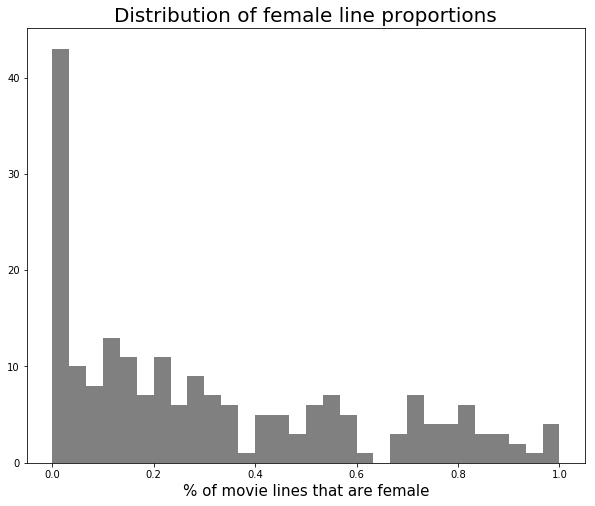

In [230]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = line_counts.pct_female
plt.figure(figsize=(10,8))
plt.hist(x, bins=30, color='gray')
plt.xlabel('% of movie lines that are female', fontsize = 15);
plt.title('Distribution of female line proportions', fontsize = 20);